# <center>CITS5017 Project 2<center>
<center>Allison Lau (23123849)<center>

# Import packages

In [1]:
import random
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Load and Prepare Data
- **`PerthA_df`**: temperature data from 1944-06 to 2024-08 (total 963 months) from *Perth Airport*
- **`PerthM_df`**: temperature data from 1994-01 to 2024-08 (total 368 months) from *Perth Metro*

In [2]:
# load the data from the pickle file
def load_data(picklefile):
    f = open(picklefile, "rb")
    dict = pickle.load(f)
    f.close()
    return dict["Perth_Airport"], dict["Perth_Metro"]

# split the data into inputs and targets
def split_data(df, inputs_length, targets_length, batch_size=32, shuffle=True, seed=42):
    # an inner function to do the splitting
    def split_inputs_and_targets(tf_ds):
        return tf_ds[:, :-targets_length], tf_ds[:, -targets_length:]

    if batch_size == -1:
        batch_size = df.shape[0]

    return tf.keras.utils.timeseries_dataset_from_array(
                tf.convert_to_tensor(df, dtype=tf.float32),
                targets = None,
                sequence_length = inputs_length + targets_length,
                batch_size = batch_size,
                shuffle = shuffle,
                seed = seed
            ).map(split_inputs_and_targets)

# Load data and display length
PerthA_df, PerthM_df = load_data("temperatures.pkl")
print(f"Total Perth Airport data: {len(PerthA_df)}")
print(f"Total Perth Metro data: {len(PerthM_df)}")

Total Perth Airport data: 963
Total Perth Metro data: 368


# Part 1 Tasks
Implement three algorithms for predicting the minimum and maximum temperatures and compare their performances.

## (a) Get training, validation, and test datasets
- **Training data**: `PerthA_df` (total 963 months)
- **Validation data**: `PerthM_df` from 1994-01 to 2013-12 (total 240 months)
- **Test data**: `PerthM_df` from 2014-01 onward (total 128 months)

In [3]:
# Split data depending on the length of the sequences
def split_data_length(df, seq_lengths, train=False):
    inputs_length, targets_length = (seq_lengths)
    if train:
        ds = split_data(df, inputs_length, targets_length, batch_size=32, shuffle=True)
    else:
        ds = split_data(df, inputs_length, targets_length, batch_size=-1, shuffle=False)
    return ds

# Separate into validation and test datasets
PerthM_val = PerthM_df.loc["1994-01":"2013-12"] # First 20 years
PerthM_test = PerthM_df.loc["2014-01":]         # Last 10 years
print(f"Total training data: {len(PerthA_df)}")
print(f"Total validation data: {len(PerthM_val)}")
print(f"Total test data: {len(PerthM_test)}")

# Split into training, validation and test datasets
train_ds = split_data_length(PerthA_df, (72, 12), train=True)
val_ds = split_data_length(PerthM_val, (72, 12))
test_ds = split_data_length(PerthM_test, (72, 12))

for batch in test_ds.take(1):
    X_test, y_test = batch

Total training data: 963
Total validation data: 240
Total test data: 128


## (b) `display_temperatures` function
- Display the minimum and maximum temperatures for 3 random samples in 1 x 3 subplots
- Plot the input sequence, target sequence, (and predicted sequence if available)
- Blue lines are the input temperature sequences (solid indicates maximum temperatures, dotted indicates minimum temperatures)
- Green lines are the target temperature sequences (solid indicates maximum temperatures, dotted indicates minimum temperatures)  

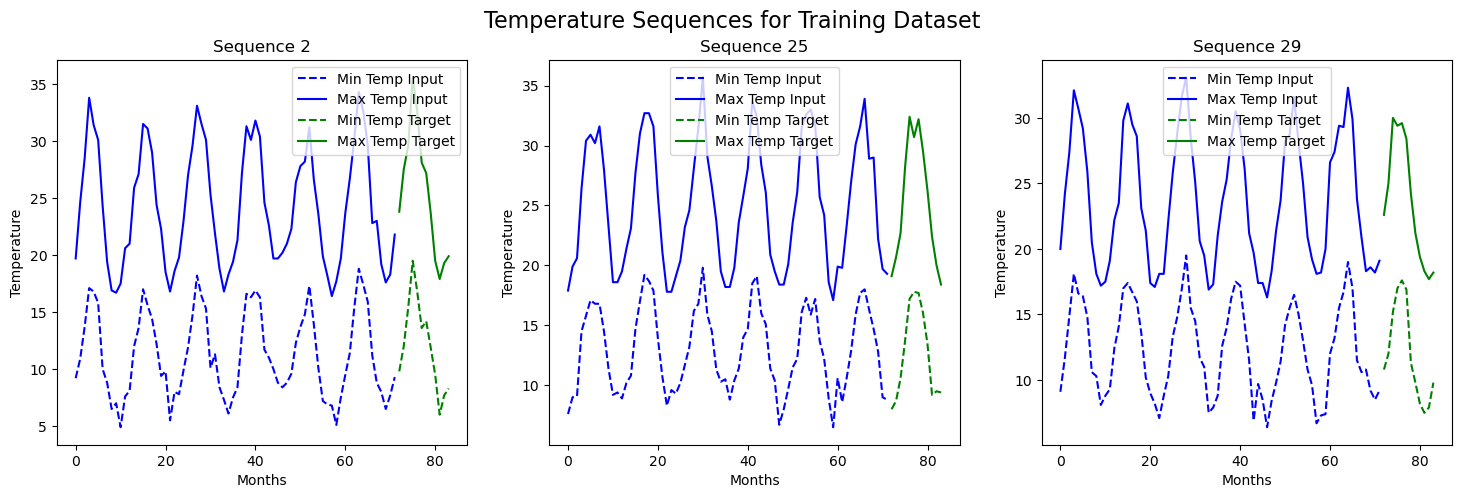

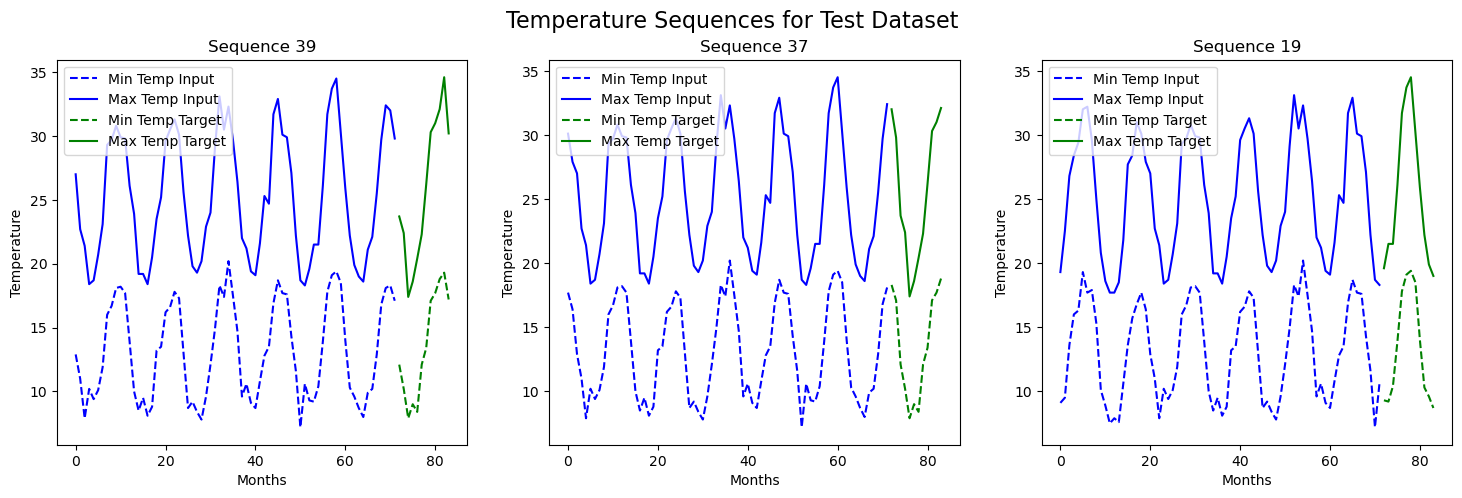

In [4]:
# Function to display 3 samples of temperature sequences (max and min)
def display_temperatures(inputs, targets, indices, preds=None, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Temperature Sequences for {title}', fontsize=16)

    for i, idx in enumerate(indices):
        input_length = inputs.shape[1]
        target_length = targets.shape[1]
        input_range = range(0, input_length)
        target_range = range(input_length, input_length+target_length)
        # Min temp sequence in column 0, Max temp sequence in column 1
        axes[i].plot(input_range, inputs[idx, :, 0], label="Min Temp Input", color='blue', linestyle='--')
        axes[i].plot(input_range, inputs[idx, :, 1], label="Max Temp Input", color='blue', linestyle='-')
        axes[i].plot(target_range, targets[idx, :, 0], label="Min Temp Target", color='green', linestyle='--')
        axes[i].plot(target_range, targets[idx, :, 1], label="Max Temp Target", color='green', linestyle='-')
        
        if preds is not None:
            pred_min = preds[idx, :, 0]
            pred_max = preds[idx, :, 1]
            axes[i].plot(target_range, pred_min, label="Min Temp Prediction", color='red', linestyle='--')
            axes[i].plot(target_range, pred_max, label="Max Temp Prediction", color='red', linestyle='-')
        
        axes[i].set_title(f"Sequence {idx}")
        axes[i].set_xlabel("Months")
        axes[i].set_ylabel("Temperature")
        axes[i].legend()

# Display 3 random sequences from the training dataset
for batch in train_ds.take(1):
    X_train, y_train = batch
    train_indices = random.sample(range(X_train.shape[0]), 3)
    display_temperatures(X_train, y_train, train_indices, title="Training Dataset")

# Display 3 random sequences from the test dataset
test_indices = random.sample(range(X_test.shape[0]), 3)
display_temperatures(X_test, y_test, test_indices, title="Test Dataset")

## (c) Model 1

### Functions (Model, Training, and Evaluation)
- **`create_gru()`**: Create 2-layer GRU model with 16 units each. The activation function used is `ReLU` to prevent vanishing gradients.
- **`train_model()`**: Train a model for 50 epochs on the training dataset.
    - **Optimiser**: The optimiser used is `Nadam` which is a variant of the Adam optimizer that incorporates Nesterov momentum. It adapts the learning rate during training, and also uses momentum to speed up convergence. 
    - **Loss function**: The loss function used is `Huber Loss` which is a combination of `MSE` and `MAE`. It is less sensitive to outliers. 
    - **Metric**: The metric used is `MAE` which is the average of the absolute differences between predictions and targets. It directly reflects the average magnitude of prediction errors without considering their direction. 
- **`plot_learning_curves()`**: Plot learning curves for training and validation datasets (metric of interest is MAE).
- **`compute_mae()`**: Compute MAE for the test dataset by comparing the predicted and target temperatures.

**Note**: All models (model 1, 2 and 3) use the same optimiser, loss function, metric, and hyperparameters for training to ensure a fair comparison.

In [5]:
# Create 2-layer GRU model with 16 units
def create_gru(input_shape, output_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(16, activation='relu', return_sequences=True),
        layers.GRU(16, activation='relu'),
        layers.Dense(output_shape[0] * output_shape[1]),
        layers.Reshape(output_shape)
    ])
    return model

# Train GRU model
def train_model(model, train_ds, val_ds, epochs=50, verbose=0):
    model.compile(optimizer='nadam', loss=tf.keras.losses.Huber(), metrics=['mae'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=verbose)
    return history

# Plot learning curves (metric of interest MAE)
def plot_learning_curves(history, title, metric='mae'):
    metric_label = 'MAE' if metric == 'mae' else 'Loss'
    plt.figure(figsize=(5, 4))
    plt.plot(history.history[f'{metric}'], label=f'Training {metric_label}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric_label}')
    plt.title(f'{title} Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error' if metric == 'mae' else 'Loss')
    plt.legend()
    plt.show()
    
# Calculate MAE between test targets and predictions
def compute_mae(y_test, y_pred, model_name=""):
    test_mae = np.mean(np.abs(y_pred - y_test))
    print(f"{model_name} Test MAE: {test_mae:.2f}")
    return test_mae

### Train Model 1
- **Input sequence**: 72 months of minimum and maximum temperatures
- **Output sequence**: 12 months of minimum and maximum temperatures

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 72, 16)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 2)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000 (11.72 KB)

 Trainable params: 3,000 (11.72 KB)

 Non-trainable params: 0 (0.00 B)

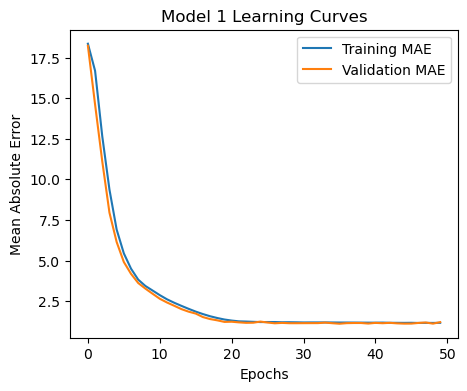

In [6]:
# Model 1: input shape (72, 2) -> output shape (12, 2)
# Create and display model 1
model1 = create_gru(input_shape=(72, 2), output_shape=(12, 2))
model1.summary()

# Train model 1 and plot learning curves
history1 = train_model(model1, train_ds, val_ds)
plot_learning_curves(history1, "Model 1")

### Evaluate Model 1
- **Input sequence**: 72 months of minimum and maximum temperatures
- **Output sequence**: 12 months of minimum and maximum temperatures
- The low test MAE and the plots showing the predicted sequences against the target sequences shows that model 1 can predict the temperature sequences relatively well.

Model 1 Test MAE: 1.37


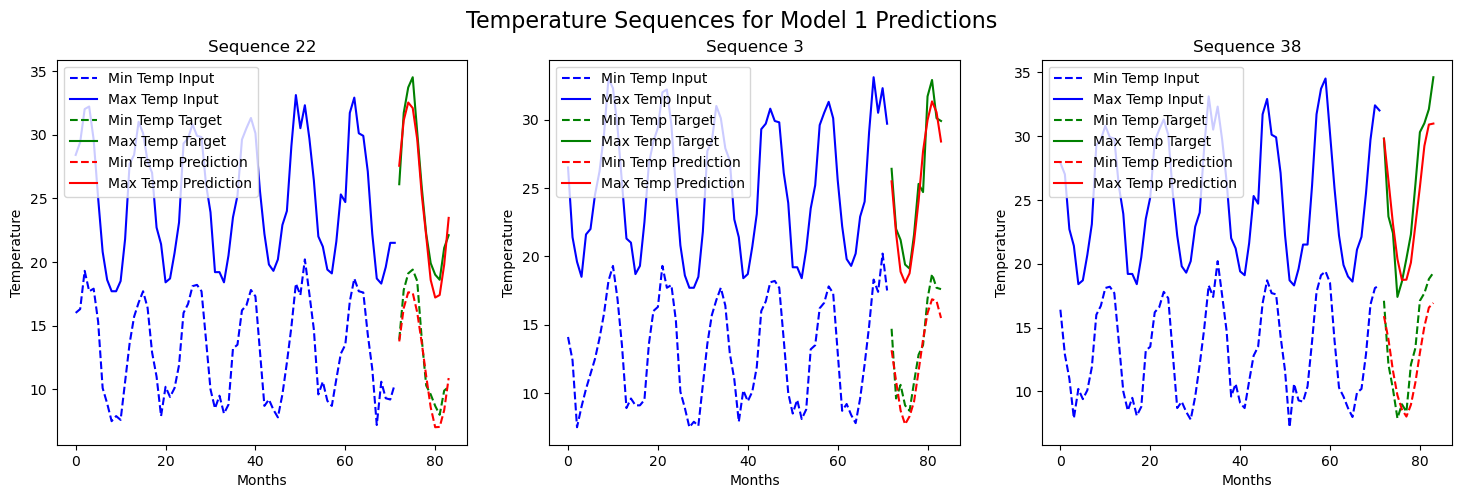

In [7]:
# Function to evaluate model 1 on the test dataset
def evaluate_model1(model, test_ds):
    _, test_mae = model.evaluate(test_ds, verbose=0)
    print(f"Model 1 Test MAE: {test_mae:.2f}")
    return test_mae

# Evaluate model 1 on the test dataset
y_pred = model1.predict(X_test, verbose=0)
mae1 = evaluate_model1(model1, test_ds)

# Display 3 random sequences with predictions
sample_indices = random.sample(range(X_test.shape[0]), 3)
display_temperatures(X_test, y_test, sample_indices, y_pred, title="Model 1 Predictions")

## (d) Model 2

### Train Model 2
- **Input sequence**: 72 months of minimum and maximum temperatures
- **Output sequence**: 1 months of minimum and maximum temperatures

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 72, 16)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 2)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,626 (10.26 KB)

 Trainable params: 2,626 (10.26 KB)

 Non-trainable params: 0 (0.00 B)

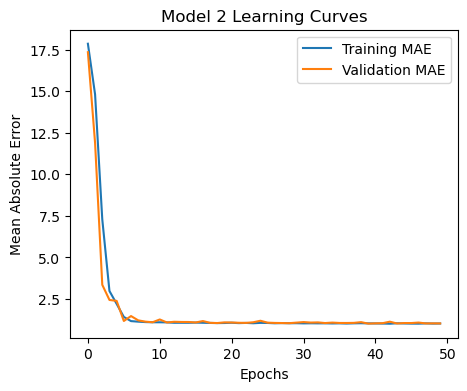

In [8]:
# Model 2: input shape (72, 2) -> output shape (1, 2)
# Split data for model 2 (output shape 1)
train_ds_output1 = split_data_length(PerthA_df, (72, 1), train=True)
val_ds_output1 = split_data_length(PerthM_val, (72, 1))

# Create and display model 2
model2 = create_gru(input_shape=(72, 2), output_shape=(1, 2))
model2.summary()

# Train model 2 and plot learning curves
history2 = train_model(model2, train_ds_output1, val_ds_output1)
plot_learning_curves(history2, "Model 2")

### Evaluate Model 2
- **Input sequence**: 72 months of minimum and maximum temperatures
- **Output sequence**: 12 months of minimum and maximum temperatures (predicted 1 month at a time)
- **`predict_months()`**: Predict 1 month at a time for `steps` number of months (default is 12 months) and update the input sequence with the predicted values.
- The low test MAE and the plots showing the predicted sequences against the target sequences shows that model 2 can predict the temperature sequences relatively well.

 Test MAE: 1.12


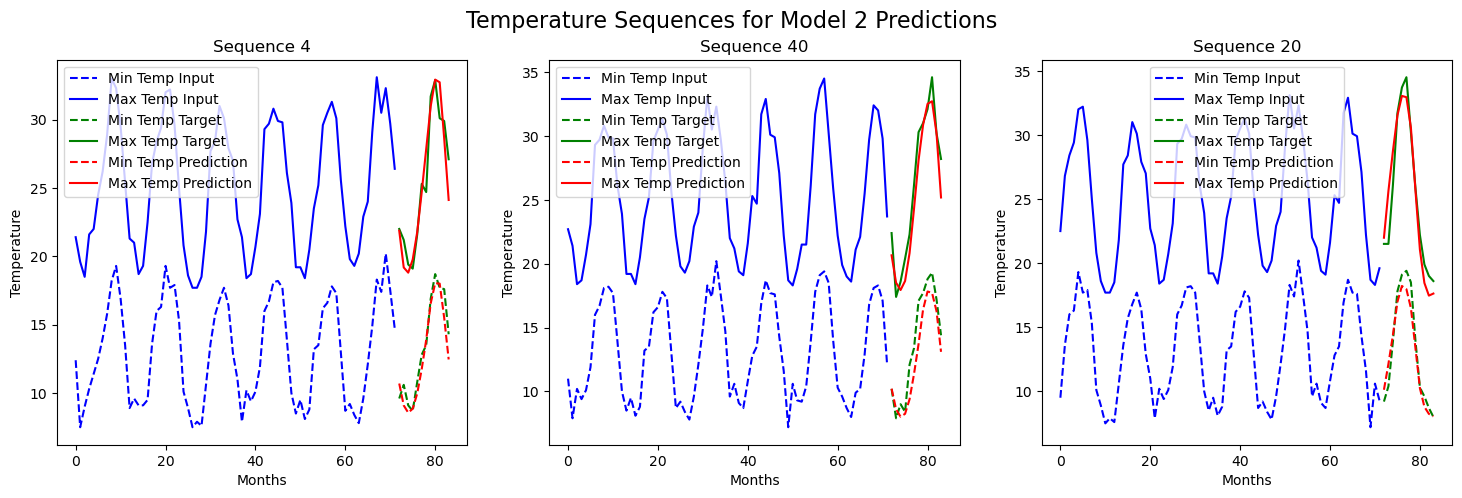

In [9]:
# Function to predict the next n months (1 at a time) for model 2
def predict_months(model, input_X, steps=12):
    X = input_X
    for step in range(steps):
        y_pred_one = model.predict(X[:, step:], verbose=0)
        X = np.concatenate([X, y_pred_one], axis=1)
    y_pred = X[:, -steps:, :]
    return np.array(y_pred)
    
# Evaluate model 2 on the test dataset
y_pred = predict_months(model2, X_test)
mae2 = compute_mae(y_test, y_pred)

# Display 3 random sequences with predictions
sample_indices = random.sample(range(X_test.shape[0]), 3)
display_temperatures(X_test, y_test, sample_indices, y_pred, title="Model 2 Predictions")

## (e) Model 3

### Prepare Datasets for Model 3 Training and Evaluation
- **Encoder Input**: 72 months of minimum and maximum temperatures
- **Decoder Input**: 12 months of minimum and maximum temperatures (shifted by 1 month)
- **Decoder Output**: 12 months of minimum and maximum temperatures

In [10]:
# Prepare dataset for training model 3
def split_XY_from_dataset(dataset):
    out = list(map(lambda lam: (lam[0], lam[1]), dataset))
    X = tf.concat( [out[i][0] for i in range(len(out))], axis = 0 )
    y = tf.concat( [out[i][1] for i in range(len(out))], axis = 0 )
    return X, y

def split_ed(dataset):
    X, y = split_XY_from_dataset(dataset)
    X_train = X[:, :-1]
    X_decode = X[:, -1:]
    X_decode = tf.concat([X_decode, y[:, :-1]], axis=1)
    return X_train, X_decode, y

X_train, X_train_decode, y_train = split_ed(train_ds)
X_valid, X_valid_decode, y_valid = split_ed(val_ds)
X_test, X_test_decode, y_test = split_ed(test_ds)
print(f"X_train shape: {X_train.shape}")
print(f"X_decode shape: {X_train_decode.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (880, 71, 2)
X_decode shape: (880, 12, 2)
y_train shape: (880, 12, 2)


### Train Model 3
- **Input sequence**: 72 months of minimum and maximum temperatures
- **Decoder Input**: 12 months of minimum and maximum temperatures (shifted by 1 month)
- **Output sequence**: 12 months of minimum and maximum temperatures (teacher forcing)

#### Model 3 Architecture
- **`create_encoder_decoder()`**: Create an encoder-decoder model with 2-layer GRU for both encoder and decoder. The encoder processes the input sequence and returns the hidden state. The decoder processes the hidden state and decoder input sequence to predict the output sequence.
- **`train_encoder_decoder()`**: Train the encoder-decoder model for 50 epochs on the training dataset.
    - **Optimiser**: The optimiser used is `Nadam`. (Refer to Model 1 for details)
    - **Loss function**: The loss function used is `Huber Loss`. (Refer to Model 1 for details)
    - **Metric**: The metric used is `MAE`. (Refer to Model 1 for details)
    - We used teacher forcing during training to predict the next time step given the previous time step. 

**Note**: Model 3 is trained using the same optimiser, loss function, metric, and hyperparameters as Model 1 and Model 2.

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ [(None, None,     │        960 │ input_layer_2[0]… │
│                     │ 16), (None, 16)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ [(None, 16),      │      1,632 │ gru_4[0][0]       │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32)        │          0 │ gru_4[0][1],      │
│ (Concatenate)       │                   │            │ gru_5[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ [(None, None,     │      3,456 │ input_layer_3[0]… │
│                     │ 32), (None, 32)]  │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ [(None, None,     │      2,400 │ gru_6[0][0]       │
│                     │ 16), (None, 16)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 2)   │         34 │ gru_7[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,482 (33.13 KB)

 Trainable params: 8,482 (33.13 KB)

 Non-trainable params: 0 (0.00 B)

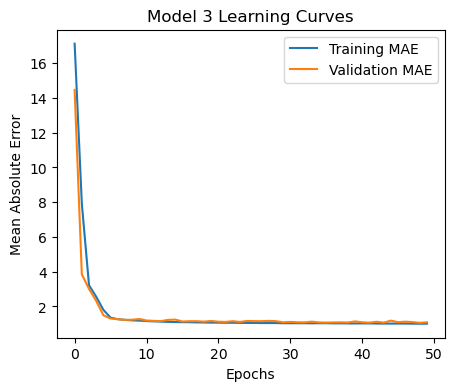

In [11]:
# Model 3: GRU Encoder-Decoder 
def create_encoder_decoder():
    # Encoder
    encoder_inputs = layers.Input(shape=(None, 2))
    encoder_gru1 = layers.GRU(16, activation='relu', return_state=True, return_sequences=True)
    encoder_gru2 = layers.GRU(16, activation='relu', return_state=True)
    encoder_outputs, encoder_state1 = encoder_gru1(encoder_inputs)
    encoder_outputs, encoder_state2 = encoder_gru2(encoder_outputs)
    encoder_states = layers.Concatenate()([encoder_state1, encoder_state2])
    
    # Decoder
    decoder_inputs = layers.Input(shape=(None, 2))
    decoder_gru1 = layers.GRU(32, activation='relu', return_sequences=True, return_state=True)
    decoder_gru2 = layers.GRU(16, activation='relu', return_sequences=True, return_state=True)
    decoder_outputs, _ = decoder_gru1(decoder_inputs, initial_state=encoder_states)
    decoder_outputs, _ = decoder_gru2(decoder_outputs)
    
    # Output
    decoder_dense = layers.Dense(2)
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Model
    model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

def train_encoder_decoder(model, X_train, X_train_decode, y_train, X_val, X_val_decode, y_val, epochs=50):
    model.compile(optimizer='nadam', loss=tf.keras.losses.Huber(), metrics=['mae'])
    history = model.fit([X_train, X_train_decode], y_train, epochs=epochs, batch_size=32,
                        validation_data=([X_val, X_val_decode], y_val), verbose=0)
    return history

# Model 3: input shape (72, 2) -> output shape (12, 2)
# Create and display model 3
model3 = create_encoder_decoder()
model3.summary()

# Train model 13 and plot learning curves
history3 = train_encoder_decoder(model3, X_train, X_train_decode, y_train, X_valid, X_valid_decode, y_valid)
plot_learning_curves(history3, "Model 3")

### Evaluate Model 3
- **Input sequence**: 72 months of minimum and maximum temperatures
- **Decoder input**: 12 months of minimum and maximum temperatures (shifted by 1 month)
- **Output sequence**: 12 months of minimum and maximum temperatures (not teacher forcing)
- **`predict_ed()`**: Predict `outseq_len` number of months using the encoder-decoder model. The decoder input is updated with the predicted values at each time step (teacher forcing is not used).
- The low test MAE and the plots showing the predicted sequences against the target sequences shows that model 3 can predict the temperature sequences relatively well.

 Test MAE: 1.19


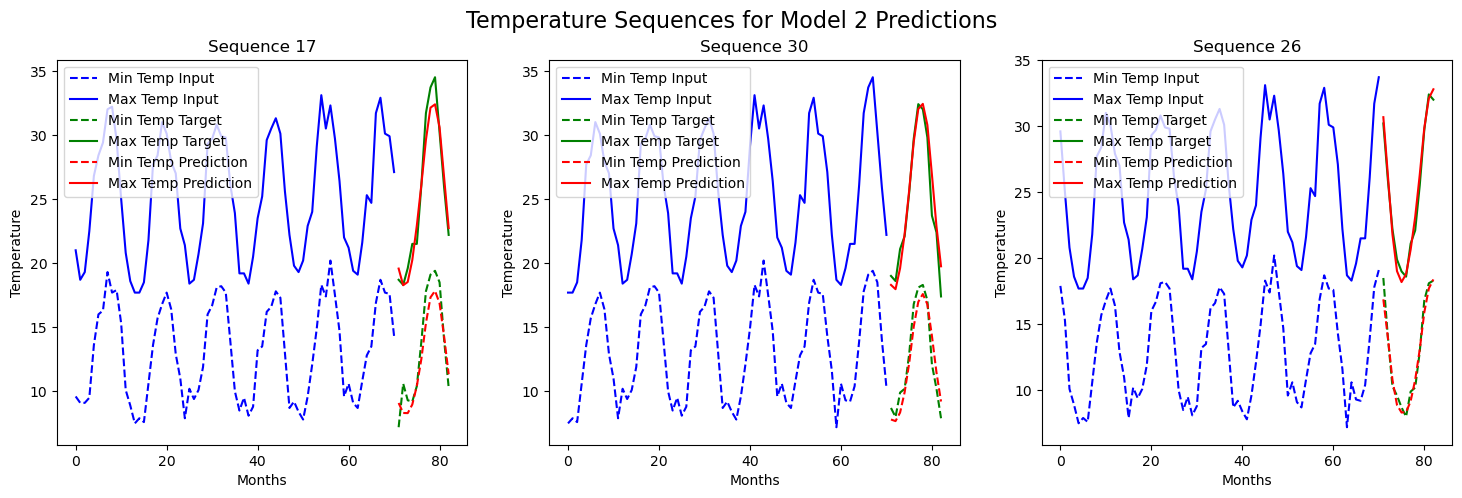

In [12]:
# Predict the next 12 months for model 3
def predict_ed(model, encoder_inputs, decoder_input, outseq_len):
    batch_size = encoder_inputs.shape[0]
    out_dim = decoder_input.shape[-1]
    outseq = np.zeros((batch_size, outseq_len, out_dim))
    decoder_ins = np.zeros((batch_size, outseq_len, out_dim))
    decoder_ins[:, 0, :] = decoder_input
    for t in range(outseq_len):
        pred = model.predict([encoder_inputs, decoder_ins], verbose=0)
        outseq = pred
        if t < outseq_len - 1:
            decoder_ins[:, t+1, :] = pred[:, t, :]
    return outseq

# Evaluate model 3 on the test dataset
y_pred = predict_ed(model3, X_test, X_test_decode[:, 0, :], 12)
mae2 = compute_mae(y_test, y_pred)

# Display 3 random sequences with predictions
sample_indices = random.sample(range(X_test.shape[0]), 3)
display_temperatures(X_test, y_test, sample_indices, y_pred, title="Model 2 Predictions")

## (f) Comparison of Models for different Target Lengths

### Train all models for different target lengths
- **Different (input_length, target_length) pairs**: (72, 12), (66, 18), (60, 24), (54, 30), (48, 36)

In [13]:
settings = [(72, 12), (66, 18), (60, 24), (54, 30), (48, 36)]
model_maes = {
    'Model 1': [],
    'Model 2': [],
    'Model 3': []
}

for input_length, target_length in settings:
    # Prepare datasets for the current setting
    train_ds = split_data_length(PerthA_df, (input_length, target_length), train=True)
    val_ds = split_data_length(PerthM_val, (input_length, target_length))
    test_ds = split_data_length(PerthM_test, (input_length, target_length))
    train_ds_output1 = split_data_length(PerthA_df, (input_length, 1), train=True)
    val_ds_output1 = split_data_length(PerthM_val, (input_length, 1))

    print(f"\nSetting: ({input_length}, {target_length})")

    # Train and evaluate Model 1
    model_1 = create_gru((input_length, 2), (target_length, 2))
    train_model(model_1, train_ds, val_ds)
    mae_1 = evaluate_model1(model_1, test_ds)
    model_maes['Model 1'].append(mae_1)

    # Train and evaluate Model 2
    model_2 = create_gru((input_length, 2), (1, 2))
    train_model(model_2, train_ds_output1, val_ds_output1)
    for batch in test_ds.take(1):
        X_test, y_test = batch
        y_pred = predict_months(model_2, X_test, steps=target_length)
    mae_2 = compute_mae(y_test, y_pred, "Model 2")
    model_maes['Model 2'].append(mae_2)

    # Train and evaluate Model 3
    X_train, X_train_decode, y_train = split_ed(train_ds)
    X_valid, X_valid_decode, y_valid = split_ed(val_ds)
    X_test, X_test_decode, y_test = split_ed(test_ds)
    model_3 = create_encoder_decoder()
    train_encoder_decoder(model_3, X_train, X_train_decode, y_train, X_valid, X_valid_decode, y_valid)
    y_pred = predict_ed(model_3, X_test, X_test_decode[:, 0, :], target_length)
    mae_3 = compute_mae(y_test, y_pred, "Model 3")
    model_maes['Model 3'].append(mae_3)


Setting: (72, 12)
Model 1 Test MAE: 1.20
Model 2 Test MAE: 1.13
Model 3 Test MAE: 1.09

Setting: (66, 18)
Model 1 Test MAE: 1.31
Model 2 Test MAE: 1.77
Model 3 Test MAE: 1.07

Setting: (60, 24)
Model 1 Test MAE: 1.19
Model 2 Test MAE: 1.37
Model 3 Test MAE: 1.02

Setting: (54, 30)
Model 1 Test MAE: 1.22
Model 2 Test MAE: 1.11
Model 3 Test MAE: 1.06

Setting: (48, 36)
Model 1 Test MAE: 1.21
Model 2 Test MAE: 1.03
Model 3 Test MAE: 1.27


### Plot MAE against target lengths for all models

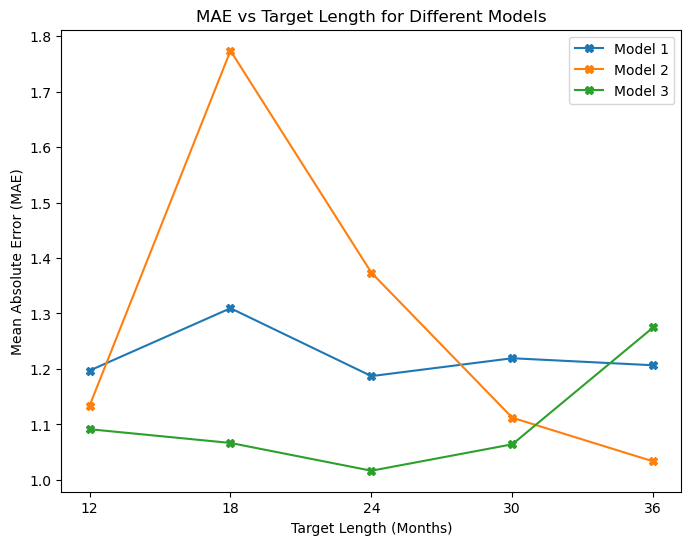

In [14]:
plt.figure(figsize=(8, 6))
for model, maes in model_maes.items():
    plt.plot([length[1] for length in settings], maes, marker='X', label=model)
plt.title('MAE vs Target Length for Different Models')
plt.xlabel('Target Length (Months)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks([length[1] for length in settings])
plt.legend()
plt.show()

### Analysis

#### Table of each model MAE on test dataset for settings (input_length, target_length)

| Setting | Model 1 MAE | Model 2 MAE | Model 3 MAE |
| --- | --- | --- | --- |
| (72, 12) |  |  |  |
| (66, 18) |  |  |  |
| (60, 24) |  |  |  |
| (54, 30) |  |  |  |
| (48, 36) |  |  |  |

**Which model deteriorates the fastest?** 

Given the MAE trends observed across the three models, it is difficult to choose a single model that deteriorates the fastest. The results indicate inconsistencies and a lack of a clear trend as the target length increases. Although we might expect higher MAEs with longer target lengths, the small test set size likely contributes to this irregularity. Retraining the models seems to help them adapt, resulting in similar performance levels across the board. As a result, no model clearly stands out as deteriorating more rapidly than the others; all exhibit comparable levels of performance despite the varying target lengths.

**How good/bad are these models in learning the temperature patterns from one weather station to predict the temperatures in another weather station?**

Based on the observations from the plotted input, target, and model-predicted sequences, the models appear to learn temperature patterns reasonably well from one weather station to predict temperatures at another. The predictions generally align closely with the actual target values, indicating that the models can capture some underlying temperature patterns. The MAE trends show inconsistencies and a lack of a clear pattern as the target length increases, likely due to the small test set size of only 45 sequences. Despite this, the models seem to adapt well when retrained, maintaining a comparable performance across different target lengths. Overall, the models exhibit a reasonable ability to predict temperatures based on learned patterns, suggesting that they can generalise well to predict temperatures at a different weather station, given that the location shares similar climatic conditions and temperature patterns.

# Part 2 Tasks
Train a variational autoencoder (VAE) to synthesize temperature data.

## Prepare Data for VAE Model
- **Input sequence**: 84 months of maximum temperatures
- **`get_max_temps()`**: Extract maximum temperature sequences from the dataset for the VAE model.
- **`min_temp`**: Minimum temperature value in the dataset (max temperature sequences).
- **`max_temp`**: Maximum temperature value in the dataset (max temperature sequences).

In [30]:
# Get max temperatures sequences
def get_max_temps(df, seq_length=84):
    max_temp = df['Mean maximum temperature (°C)'].values
    sequences = []
    for i in range(len(max_temp) - seq_length + 1):
        sequences.append(max_temp[i:i + seq_length])
    sequences = np.array(sequences)
    return sequences

# Get the max temperature sequences
X_train_vae = get_max_temps(PerthA_df)
X_valid_vae = get_max_temps(PerthM_val)
print(f"X_train shape: {X_train_vae.shape}")
print(f"X_valid shape: {X_valid_vae.shape}")

# Get min and max of the max temperature sequences for rescaling
min_temp = np.min(X_train_vae)
max_temp = np.max(X_valid_vae)
print(f"Min temperature: {min_temp}")
print(f"Max temperature: {max_temp}")

X_train shape: (880, 84)
X_valid shape: (157, 84)
Min temperature: 16.2
Max temperature: 34.6


## Train VAE model
- **Varational Encoder**: First dense layer uses 150 units and `ReLU` activation function to provide higher-dimensional feature space to capture more complex relationships. Second dense layer uses 100 units and `ReLU` activation function to reduce dimensionality to focus on important features. Dense layers to learn the mean and logarithmic variance of the latent space.
- **Variational Decoder**: First dense layer uses 100 units and `ReLU` activation function to increase dimensionality to reconstruct the original feature space. Second dense layer uses 150 units and `ReLU` activation function to further increase dimensionality for reconstruction. Output layer is reshaped to match the input shape to reconstruct the original input data.
- **Variational Autoencoder**: Combines the encoder to learn the latent space and the decoder to reconstruct the input.
- **Input Rescaling**: The input temperature data is normalised to the range `[0, 1]`.
- **Output Rescaling**: The output temperature data is rescaled back to the original temperature range `[min_temp, max_temp]`.

- **`codings_size`**: Size of the latent space is set to `3` which helps the model to focus on important patterns without overfitting.
- The VAE model is trained for 50-100 epochs on the training dataset.
    - **Optimiser**: The optimiser used is `Nadam` due to its ability to handle sparse gradients.
    - **Loss function**: The loss function used is `MSE` to measure the difference between the reconstructed output and the original input. The VAE model trains to minimise the reconstruction error and latent loss.
    - **Batch size**: The batch size used is `32` for faster computation, memory efficiency and better generalisation.
    - **Learning curve**: The learning curve is plotted to visualise the training and validation loss.

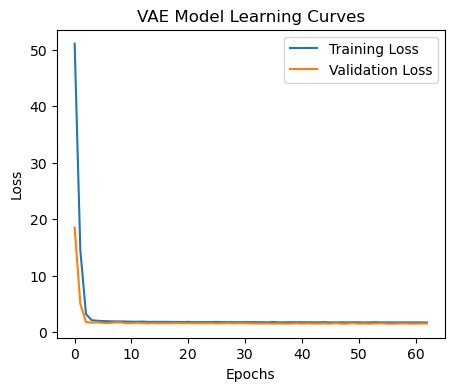

In [31]:
# Define a customised layer
class Sampling(tf.keras.Layer):
    def call(self, inputs):
        mean, logvar = inputs
        # Define the latent loss and add it to the loss function
        latent_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.exp(logvar) - tf.square(mean), axis=-1) / 784.
        self.add_loss(latent_loss)
        return tf.random.normal(tf.shape(logvar)) * tf.exp(logvar / 2) + mean

# Variational Autoencoder (VAE) model
def create_vae(input_shape, codings_size, min_temp, max_temp):
    range_temp = max_temp - min_temp
    
    # Encoder part of the VAE
    inputs = layers.Input(shape=input_shape)
    scaled = layers.Rescaling(1.0/range_temp, offset=-min_temp/range_temp)(inputs)
    Z = layers.Dense(150, activation="relu")(scaled)
    Z = layers.Dense(100, activation="relu")(Z)
    codings_mean = layers.Dense(codings_size)(Z) # mu
    codings_log_var = layers.Dense(codings_size)(Z) # gamma
    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = tf.keras.Model(inputs=inputs, outputs=[codings_mean, codings_log_var, codings])

    # Decoder part of the VAE
    decoder_inputs = tf.keras.Input(shape=[codings_size])
    x = layers.Dense(100, activation="relu")(decoder_inputs)
    x = layers.Dense(150, activation="relu")(x)
    x = layers.Dense(input_shape[0])(x)
    outputs = layers.Reshape(input_shape)(x)
    rescaled = layers.Rescaling(range_temp, offset=min_temp)(outputs)
    variational_decoder = tf.keras.Model(inputs=decoder_inputs, outputs=rescaled)

    # Join encoder and decoder together to form VAE
    _, _, codings = variational_encoder(inputs)
    reconstructions = variational_decoder(codings)
    variational_ae = tf.keras.Model(inputs=inputs, outputs=reconstructions)

    return variational_ae, variational_encoder, variational_decoder

# Create the VAE model
codings_size = 3
vae, vae_encoder, vae_decoder = create_vae(input_shape=(84,), codings_size=codings_size, 
                                           min_temp=min_temp, max_temp=max_temp)

# Train the VAE model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
vae.compile(loss='mse', optimizer='nadam')
history = vae.fit(X_train_vae, X_train_vae, validation_data=(X_valid_vae, X_valid_vae), 
                  epochs=100, batch_size=32, callbacks=[early_stopping_cb], verbose=0)
plot_learning_curves(history, "VAE Model", metric='loss')

## Report Mean and Logarithmic Variance
- The mean of the latent space indicates the central tendency of the latent variables.
- The logarithmic variance of the latent space indicates the spread of the latent variables.

In [32]:
# Report the mean and logarithmic variance of the learned distribution
mean, logvar, _ = vae_encoder.predict(X_train_vae, verbose=0)
mean_avg = [round(x, 3) for x in np.mean(mean, axis=0)]
logvar_avg = [round(x, 3) for x in np.mean(logvar, axis=0)]
print("Mean:", mean_avg)
print("Logarithmic Variance:", logvar_avg)

Mean: [-1.642, 0.292, 0.644]
Logarithmic Variance: [-7.395, -7.223, -7.146]


## Synthesise Temperature Sequences

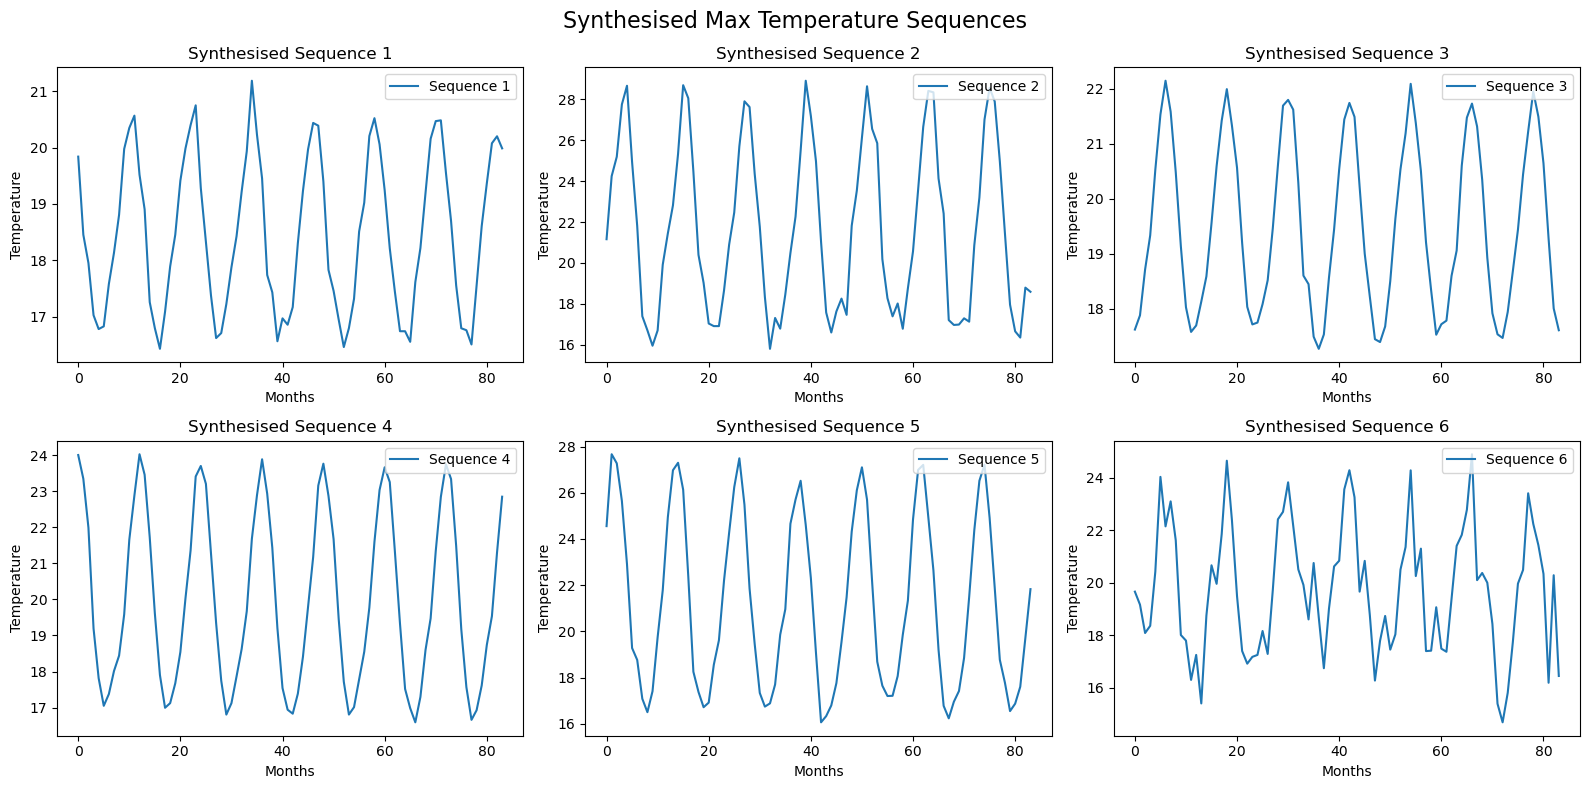

In [33]:
# Function to plot the synthesised sequences
def plot_synthesised_sequences(sequences, num_cols=3):
    num_rows = len(sequences) // num_cols + (len(sequences) % num_cols > 0)
    plt.figure(figsize=(16, 8))
    
    for i, seq in enumerate(sequences):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.plot(seq, label=f'Sequence {i + 1}')
        plt.title(f'Synthesised Sequence {i + 1}')
        plt.xlabel('Months')
        plt.ylabel('Temperature')
        plt.suptitle('Synthesised Max Temperature Sequences', fontsize=16)
        plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.5)
    
    plt.tight_layout()
    plt.show()

# Generate synthetic max temperature sequences
num_samples = 6
codings = tf.random.normal(shape=(num_samples, codings_size))
synthetic_max_temps = vae_decoder.predict(codings, verbose=0)
plot_synthesised_sequences(synthetic_max_temps)

### Discussion
- Overall, the VAE model was able to successfully synthesise temperature sequences that closely resemble and imitate real data patterns. The generated sequences show similar fluctuations and trends to the original data. This means that the VAE model was able to learn the patterns in the training data and generate similar pattern temperature sequences.